In [28]:
import sys
sys.path.append('../src')
# from causal_shapley import causal_shapley, predict_proba
from egtoolkit import *
%load_ext autoreload
%autoreload 2

from egtoolkit import *

import random
import warnings
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import itertools
from itertools import combinations, permutations, chain
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mutual_info_score

from functools import reduce
from decimal import Decimal
import itertools

import shap

warnings.filterwarnings("ignore")
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler

from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete.CPD import TabularCPD


from graphviz import Digraph
import pydot
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# !pip list

## Import dataset

In [4]:
categorical_cols = ['global_active_power', 'global_reactive_power', 'voltage',
                    'global_intensity', 'kitchen', 'laundry', 'climate_control', 'other',
                    'weekend', 'month_name', 'season_name', 'day_name']  # list all columns that are categorical

In [5]:
dataset = pd.read_csv('./datasets/2.0-discretized-v2-3-peak-label-encoded.csv')

In [6]:
dataset[['peak_warning']].values

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [7]:
targets = ['peak_label_pred', 'peak_warning', 'no_significant_change', 'lower_than_usual']
targets_only = ['peak_label_pred', 'no_significant_change', 'lower_than_usual']

In [8]:
dataset.columns

Index(['global_active_power', 'global_reactive_power', 'voltage',
       'global_intensity', 'kitchen', 'laundry', 'climate_control', 'other',
       'weekend', 'month_name', 'season_name', 'day_name', 'peak_label_pred',
       'peak_warning', 'no_significant_change', 'lower_than_usual'],
      dtype='object')

MI Sort

In [9]:
causal_vars = ['climate_control','global_intensity','kitchen','laundry','other','voltage','weekend', 'peak_warning']
dataset_preprocessing = dataset[causal_vars]
dataset_preprocessing

,climate_control,global_intensity,kitchen,laundry,other,voltage,weekend,peak_warning
0,High,Very High,High,Medium,Very High,Low,True,False
1,High,High,Low,Low,High,High,False,False
2,Very High,Very High,Medium,Medium,Very High,High,False,False
3,Low,Low,Medium,Low,Medium,Low,False,False
4,Low,Very High,Low,Low,Very High,Very High,True,False
...,...,...,...,...,...,...,...,...
41668,Low,Low,Low,Low,Medium,Very High,True,False
41669,Medium,Medium,High,Medium,High,Very High,False,False
41670,Low,Medium,Low,High,High,High,False,False
41671,Medium,Low,High,High,Low,Very High,True,False


In [10]:
# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each column
for col in dataset_preprocessing.columns:
    dataset_preprocessing[col] = le.fit_transform(dataset_preprocessing[col])

In [11]:
# Prepare an empty DataFrame to store mutual information
mi_matrix = pd.DataFrame(index=dataset_preprocessing.columns, columns=dataset_preprocessing.columns)

# Calculate mutual information for each pair of columns
for col1 in dataset_preprocessing.columns:
    for col2 in dataset_preprocessing.columns:
        mi_matrix.loc[col1, col2] = mutual_info_score(dataset_preprocessing[col1], dataset_preprocessing[col2])

print(mi_matrix.values)


[[1.3748624052229603 0.2918502082238087 0.3196853707866573
  0.06627524257671642 0.037659607081020396 0.0503604623530874
  0.0006325003465987022 0.09426270891192148]
 [0.2918502082238087 1.3733068821830432 0.04214078617042706
  0.046260120346218125 0.41624975079542736 0.10048726791888057
  0.002922910585734295 0.15097777384148847]
 [0.3196853707866573 0.04214078617042706 1.38286802432115
  0.260686249324554 0.010542826604020783 0.044340309486752896
  0.0023339804933382724 0.020583936653749024]
 [0.06627524257671642 0.046260120346218125 0.260686249324554
  1.3854443909985528 0.007645556847585777 0.030925773163837364
  0.0010848848257274668 0.005839022333192917]
 [0.037659607081020396 0.4162497507954274 0.010542826604020783
  0.007645556847585777 1.379847170104834 0.061686982120370173
  0.0022612178958185125 0.06990186563545549]
 [0.0503604623530874 0.10048726791888057 0.044340309486752896
  0.030925773163837364 0.061686982120370173 1.3791596177645482
  0.00013741577370590674 0.084805339

In [12]:
influence_scores = mi_matrix.sum() - np.diag(mi_matrix)
sorted_features = influence_scores.sort_values(ascending=False)
print("Features sorted by influence score:")
print(sorted_features)

Features sorted by influence score:
global_intensity    1.050889
climate_control     0.860726
kitchen             0.700313
other               0.605948
peak_warning        0.426687
laundry             0.418717
voltage             0.372744
weekend             0.009689
dtype: object


In [13]:
mi_matrix['peak_warning']['voltage']

0.08480533965934756

K2 Algorithm

_Code implementation from https://github.dev/ruteee/K2-Algorithm_

In [18]:
def graph_from_dict(dictionary,):
    edge_style = ""
    g = Digraph()
   
    for k in dictionary.keys():
        if any([k in sub for sub in dictionary.values() for key in dictionary.keys()]) or dictionary[k]:
            g.node(str(k),k, shape='oval', fontsize='10', width='0', style='filled', fillcolor='#c9c9c9', color="gray") 

    for k, i in dictionary.items():
        for it in i:
            g.edge(str(it), str(k), label='',style= edge_style, color='black')  
    return g

In [19]:
def alpha(df, i, parents): 
    parents = np.sort(parents)
    states = list(map(list, itertools.product([0, 1], repeat=len(parents)+1)))
    states_mod = [["".join(map(str,sublist[:len(sublist)-1]))]+[str(sublist[-1])] for sublist in states]
    gpd_values = pd.DataFrame()
  
    if len(parents):
        label_parents = ''.join(parents)
        df_to_group = pd.DataFrame(columns = [label_parents, df.columns[i]],
                                    data = np.transpose(
                                        [df.astype(str)[parents].apply(lambda x: "".join(x), axis=1).values,
                                        [str(item) for item in df[df.columns[i]]]]))

        
        gpd_values = df_to_group.groupby(by=
                                         [df_to_group[label_parents],
                                          df.columns[i]]).size()

        gpd_values = gpd_values.reset_index(name='size')

        for state in states_mod:
            if not state in gpd_values[[label_parents, df.columns[i]]].values.tolist() :
                gpd_values.loc[len(gpd_values)] = state+[0]
                gpd_values.sort_values(by=[label_parents, df.columns[i]], inplace=True)
        gpd_values.reset_index(inplace=True)
        gpd_values = gpd_values['size']
    
    else:
        gpd_values = df.groupby(df.columns[i]).size().values
    return gpd_values

In [20]:
def get_N(df, i, parents):
    parents = np.sort(parents)
    states = list(map(list, itertools.product([0, 1], repeat=len(parents))))
    gpd_values = None
    N = []
    if len(parents):
        cols_to_group = ([index for index in parents])
        cols_to_group.insert(0,df.columns[i])
        N = df[cols_to_group].groupby(cols_to_group[1:]).size()
        N = N.reset_index(name='size')
    
        for state in states:
            if not state in N[cols_to_group[1:]].values.tolist() :
                N.loc[len(N)] = state+[0]
                N.sort_values(by=cols_to_group[1:], inplace=True)
        N.reset_index(inplace = True)
        N = N['size']
    else:
        N = df.groupby(by=df.columns[i]).size().values.sum()
    return N

In [21]:
def f_mdl(df,x_i,pi, c):
    
    '''
        Minimum Length description metric score implementation
    '''
    N = len(df)
    r_i = len(df[df.columns[x_i]].unique())
    q_i = reduce(lambda x, y: x*y, [len(pd.unique(df[pai].values)) for pai in pi]) if pi  else 0
    Nij = get_N(df, x_i, pi)
    Nijk = alpha(df, x_i, pi)
    pbs = 0
  
    if(pi):
        for j in np.arange(0,q_i):
            for i in np.arange(0,r_i):
                if (len(Nijk) > (2*j + i) and len(Nij)>j):
                    if Nijk[2*j + i] and Nij[j]:
                          pbs += Nijk[2*j + i]*(math.log(Nijk[2*j + i]) - math.log(Nij[j]))          
                    elif Nij[j]:
                        pbs += - math.log(Nij[j])
        pbs += -(c/2)*math.log(N)*q_i*(r_i -1)
    else:
        for i in np.arange(0,r_i):
            pbs += Nijk[i]*(math.log(Nijk[i]) - math.log(Nij))
        pbs += -(c/2)*math.log(N)*(r_i -1)
  
    return pbs

In [22]:
def f_ch(df, x_i, pi):
    '''
        Cooper-Herskovits metric score
        You can substitue factorial evaluations by log sum evaluations when working with large data
    '''
    prod = 1
#     prod = 0
    r_i = len(df[df.columns[x_i]].unique())
    alfa = alpha(df, x_i, pi)
    q_i = reduce(lambda x, y: x*y, [len(pd.unique(df[pai].values)) for pai in pi]) if pi  else 0
    Nij = get_N(df, x_i, pi)

    if pi:
        for j in np.arange(0,q_i):
            prod *= math.factorial(r_i - 1)/math.factorial(Nij[j] + r_i - 1)
#             prod += math.log(math.factorial(r_i - 1)) - math.log(math.factorial(Nij[j] + r_i - 1))
            for i in np.arange(0,r_i):
                prod *= math.factorial(alfa[2*j + i])
#             prod += math.log(math.factorial(alfa[2*j + i]))
    else:
        prod *= math.factorial(r_i - 1)/math.factorial(Nij + r_i - 1)
#         prod += math.log(math.factorial(r_i - 1)) - math.log(math.factorial(Nij + r_i - 1))
        for i in np.arange(0, r_i):
#             prod += math.log(math.factorial(alfa[i]))
            prod *= math.factorial(alfa[i])
    return prod

In [23]:
def k2(df_cases, tree_ogn,  c=1):
    
    '''K2 algorithm implementation
    
        df_cases: The dataframe of cases referrring the bayesian network, the columns are all the nodes 
        of the K2 pre-order         
        tree_ogn: A dictionary with the pre-order, 
            format required is {'node':[ 'parent_1', 'parent_2', ... 'parent_n'],
                                'node2': ['parent_1', 'parent_2', ... 'parent_n'],
                                'node_n: [['parent_1', 'parent_2', ... 'parent_n']]'}
        c: A factor for used in the evaluation of MDL score metric. Default = 1, (Optional)
    
        '''
    tree = copy.deepcopy(tree_ogn)
    dict_p = {}
  
    sigma = 0
    parents = [[] for node in df_cases.columns]
   
    count = 0
    for xi, col in enumerate(df_cases.columns):
        df = df_cases.copy()

        pold = f_ch(df_cases, xi, parents[xi])
        
#         using mdl as the metric score
#         pold = f_mdl(df_cases, xi, parents[xi], c)
    
        tree_xi = []
        if tree:
              tree_xi = tree[col]
    
        f_ances = []
        while (True):
            test_parents = [parents[xi]+[ances] for ances in tree_xi] if tree_xi else []
            f_ances = [f_ch(df, xi,parent) for parent in test_parents] if test_parents else [f_ch(df, xi, test_parents)]
            
            #using mdl as the score metric
            #f_ances = [f_mdl(df, xi,parent,c) for parent in test_parents] if test_parents else [f_mdl(df, xi, test_parents,c)]
            j_max = np.argmax(f_ances)

            sigma = f_ances[j_max]> pold
        
            if sigma:
                parents[xi] = parents[xi] + [no for no in [tree_xi[j_max]] if no not in parents[xi]]
                pold = f_ances[j_max]
  
            if tree_xi:
                del tree_xi[j_max]
      
            if(not sigma) or  (not tree_xi):
                break
        
    for i,parent in enumerate(parents):
        dict_p[df_cases.columns[i]] = parent
    return dict_p

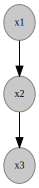

In [24]:
#Example with fake data 
#In this tree x1 has no parents, x2 has x1 as its parent and x3 hass x2 as its parents"

fake_tree = {'x1':[],
             'x2':['x1'],
             'x3':['x2']} 
    
graph_from_dict(fake_tree)

In [37]:
#dataframe with cases for the fake treee
fake_data = pd.DataFrame(columns=["x1", "x2", "x3"], data= np.transpose([[1,1,0,1,0,0,1,0,1,0], [0,1,0,1,0,1,1,0,1,0], [0,1,1,1,0,1,1,0,1,0]]))
display(fake_data)

,x1,x2,x3
0,1,0,0
1,1,1,1
2,0,0,1
3,1,1,1
4,0,0,0
5,0,1,1
6,1,1,1
7,0,0,0
8,1,1,1
9,0,0,0


In [38]:
#Example of running of K2 using Cooper-Herkovitz score metric

#In MDL score the default value to 'c' is 1. 
#If you want to use Cooper-Herskovits metric score metric do not pass the 'c' param
#In this implementation you have the possibility of changing the third parameter 'c' for MDL score

result = k2(fake_data,fake_tree)
print(result)

{'x1': [], 'x2': ['x1'], 'x3': ['x2']}


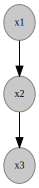

In [30]:
#Plot of the result obtained by K2
graph_from_dict(result)